# Resampling DES Y1

The DES Y1 3x2pt analysis is a tricky beast because it has SO many parameters (26). Samplers don't know the marginal likelihoods of only the interesting parameters (cosmology), and only ever report the joint posterior of all parameters given the data. For this reason, if we want to resample the DES Y1 chain, we have to traing the Gaussian processes on all parameters in the chain.

In [1]:
#Import things
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import scipy.optimize as op
import chainconsumer as CC
import emcee #for doing MCMC
%matplotlib inline

In [2]:
#Plot formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#Read in the chain
input_chain = np.load("DES_data/DES_vc_params.npy")
lnpost = np.load("DES_data/DES_vc_lnpost.npy")
weights = np.load("DES_data/DES_vc_weights.npy")
print("chain shape is   ", input_chain.shape)
print("lnpost shape is  ", lnpost.shape)
print("weights shape is ", weights.shape)

('chain shape is   ', (644696, 26))
('lnpost shape is  ', (644696,))
('weights shape is ', (644696,))


In [4]:
#Pick out training points
N_training = 800
IS = isamp.ImportanceSampler(input_chain, lnpost, scale = 5)
IS.select_training_points(N_training, method="LH")

In [5]:
#Train the GP inside of the sampler
IS.train()

      fun: 174097.91014366422
 hess_inv: array([[6.83379041e-07]])
      jac: array([1.86586112e-06])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 6
     njev: 80
   status: 0
  success: True
        x: array([3.13087938])


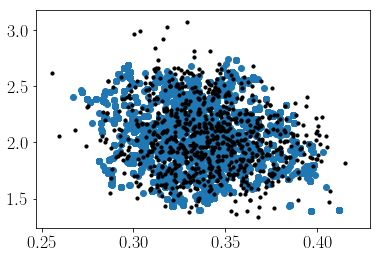

In [6]:
plt.scatter(input_chain[-10000:,4],input_chain[-10000:,0])
points,_ = IS.get_training_data()
plt.scatter(points[:,4], points[:,0], c='k', s=10)

In [7]:
#Resample the chain with an MCMC
start = np.loadtxt("DES_data/DES_vc_bestfit.txt")

nwalkers = 200
ndim = len(input_chain[0])

sampler = emcee.EnsembleSampler(nwalkers, ndim, IS.predict)

print("Running first burn-in")
p0 = np.array([start + start*1e-3*np.random.randn(ndim) for i in range(nwalkers)])
p0, lp, _ = sampler.run_mcmc(p0, 1000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + p0[np.argmax(lp)]*1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 5000);

Running first burn-in
Running second burn-in
Running production...


In [8]:
test_chain = sampler.flatchain
#print("Means and stds of input chain: ", np.mean(input_chain, 0)[:4], np.std(input_chain, 0)[:4])
#print("Means and stds of test chain:  ", np.mean(test_chain, 0)[:4], np.std(test_chain, 0)[:4])

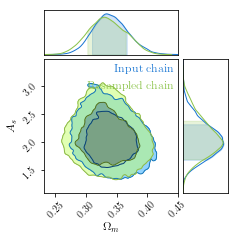

In [9]:
c = CC.ChainConsumer()

plot_input_chain = [input_chain[:,4], input_chain[:,0]]
plot_test_chain = [test_chain[:,4], test_chain[:,0]]

#labels = [r"$\Omega_m$", r"$h$", r"$\Omega_b$", r"$n_s$", r"$A_s$"]
labels = [r"$\Omega_m$", r"$A_s$"]

c.add_chain(plot_input_chain, parameters=labels, name="Input chain", weights=weights)
c.add_chain(plot_test_chain, parameters=labels, name="Resampled chain")

fig = c.plotter.plot()
#fig.savefig("DESY1_resampling_example.png", dpi=300, bbox_inches="tight")

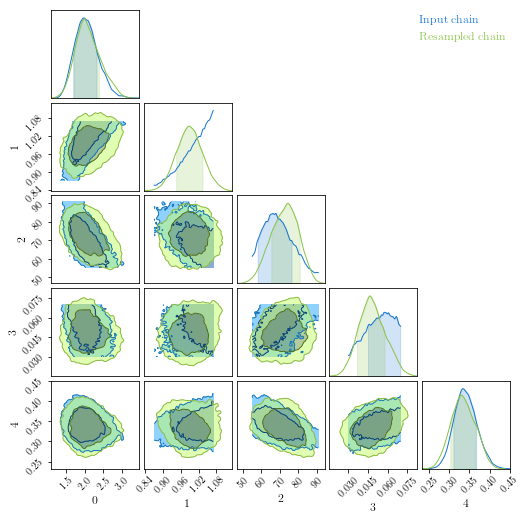

In [11]:
c2 = CC.ChainConsumer()

c2.add_chain(input_chain[:,:5], name="Input chain", weights=weights)
c2.add_chain(test_chain[:,:5], name="Resampled chain")

fig = c2.plotter.plot()
#fig.savefig("DESY1_resampling_example.png", dpi=300, bbox_inches="tight")